<a href="https://colab.research.google.com/github/OmarAlsaqa/Race_Ethnicity/blob/master/Race_Ethnicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -xf "/content/drive/My Drive/Copy of Copy of UTKFace.tar.gz"

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_DIR = "/content/UTKFace" #/content/UTKFace
TRAIN_TEST_SPLIT = 0.9
IM_WIDTH = IM_HEIGHT = 198

ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())

ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [0]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [0]:
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [0]:
attributes = list(map(parse_filepath, files))

/content/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/content/UTKFace/39_1_20170116174525125.jpg.chip.jpg
/content/UTKFace/61_1_20170109142408075.jpg.chip.jpg


In [0]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna() #remove empty rows
df.head()

,age,gender,race,file
0,32.0,male,indian,/content/UTKFace/32_0_3_20170119200231708.jpg....
1,26.0,female,asian,/content/UTKFace/26_1_2_20170116184655060.jpg....
2,38.0,male,white,/content/UTKFace/38_0_0_20170117184839544.jpg....
3,28.0,female,white,/content/UTKFace/28_1_0_20170117121929252.jpg....
4,42.0,male,white,/content/UTKFace/42_0_0_20170117203914696.jpg....


In [0]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


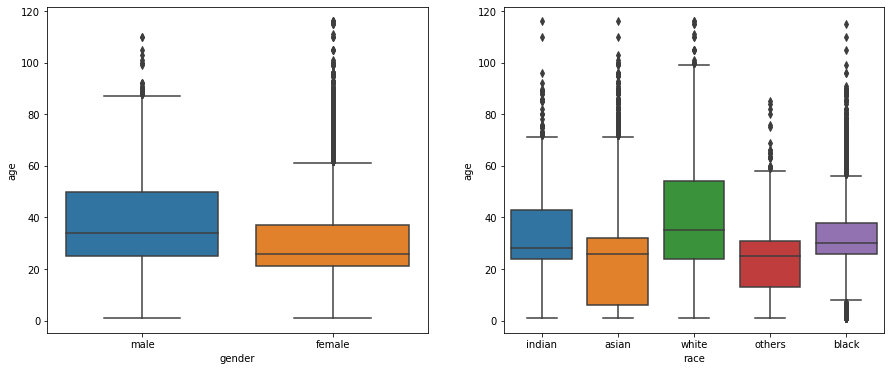

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

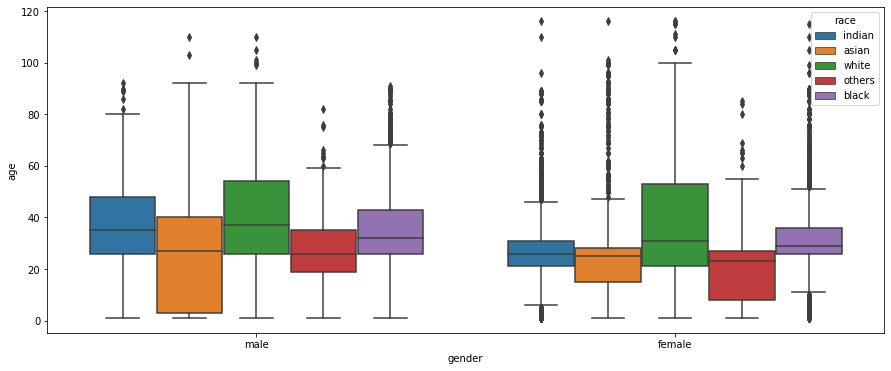

In [0]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

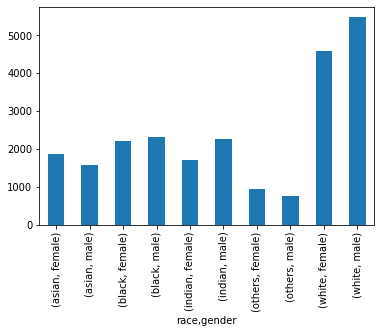

In [0]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

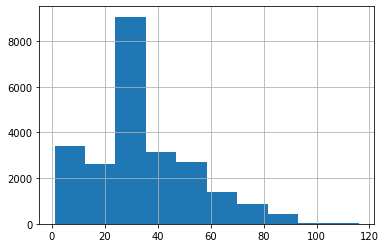

In [0]:
df['age'].hist()

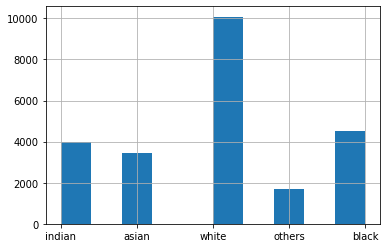

In [0]:
df['race'].hist()

In [0]:
#df['age'].describe()

In [0]:
#df = df[(df['age'] > 15) & (df['age'] < 70)]

In [0]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.8)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age-5

(17067, 4267, 2371, 111.0)

In [0]:
from keras.utils import to_categorical
from PIL import Image

In [0]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            if race == 4:
              race = 3
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0 #normalization
            images.append(im)
            ages.append(age / max_age) #norm
            races.append(to_categorical(race, len(RACE_ID_MAP)-1))
            genders.append(to_categorical(gender, 2)) 
            if len(images) >= batch_size:
                yield np.array(images), np.array(races)
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

## **Model**

In [0]:
import keras
# change the label_smoothing value (0.1 for example) and compare results  
def Loss_compute(y_true, y_pred, label_smoothing=0.1):
    loss = keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [0]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPool2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.models import Model, Sequential

model = Sequential()

## CNN 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(198, 198, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

## CNN 2
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

## CNN 3
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))

## Output
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(RACE_ID_MAP)-1,activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), 
              loss=Loss_compute,
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 196, 196, 32)      896       
_________________________________________________________________
batch_normalization_33 (Batc (None, 196, 196, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 49, 49, 32)       

In [0]:
batch_size = 32
valid_batch_size = 32

train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

In [0]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.90):
            print("\nReached more than 90% validation accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [0]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=50,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size,
                    callbacks=[callbacks])

Epoch 1/50
533/533 [==============================] - 78s 147ms/step - loss: 1.2714 - accuracy: 0.4750 - val_loss: 1.2505 - val_accuracy: 0.4330
Epoch 2/50
533/533 [==============================] - 75s 141ms/step - loss: 1.0581 - accuracy: 0.5933 - val_loss: 0.8676 - val_accuracy: 0.6516
Epoch 3/50
533/533 [==============================] - 76s 142ms/step - loss: 0.9530 - accuracy: 0.6696 - val_loss: 0.8260 - val_accuracy: 0.7025
Epoch 4/50
533/533 [==============================] - 76s 142ms/step - loss: 0.8946 - accuracy: 0.7146 - val_loss: 0.9146 - val_accuracy: 0.7086
Epoch 5/50
533/533 [==============================] - 75s 141ms/step - loss: 0.8649 - accuracy: 0.7333 - val_loss: 1.0329 - val_accuracy: 0.7190
Epoch 6/50
533/533 [==============================] - 75s 141ms/step - loss: 0.8449 - accuracy: 0.7453 - val_loss: 0.8614 - val_accuracy: 0.7728
Epoch 7/50
533/533 [==============================] - 76s 142ms/step - loss: 0.8218 - accuracy: 0.7640 - val_loss: 1.2975 - val_ac

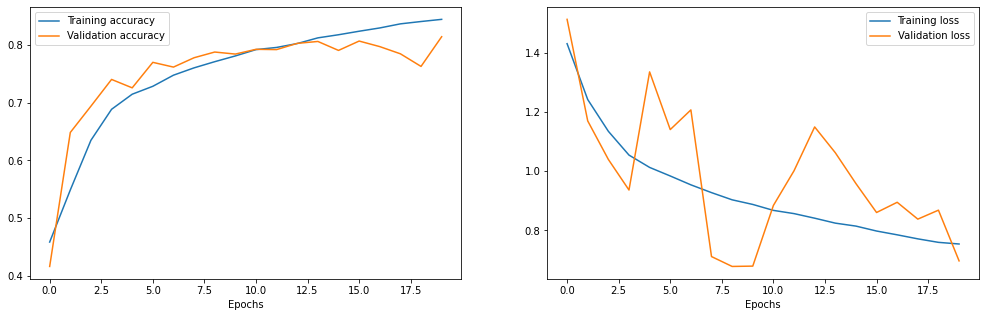

In [0]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(17, 5))
    axes[0].plot(history.history['accuracy'], label='Training accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'accuracy': 0.8168402910232544, 'loss': 0.8173420429229736}

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=512)
x_test, race_true= next(test_gen)
race_pred = model.predict_on_batch(x_test)

In [0]:
race_true = race_true.argmax(axis=-1)
race_pred = race_pred.argmax(axis=-1)

In [0]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       227
           1       0.87      0.91      0.89       102
           2       0.85      0.82      0.84        74
           3       0.77      0.81      0.79        75
           4       0.44      0.12      0.19        34

    accuracy                           0.83       512
   macro avg       0.76      0.72      0.72       512
weighted avg       0.81      0.83      0.82       512



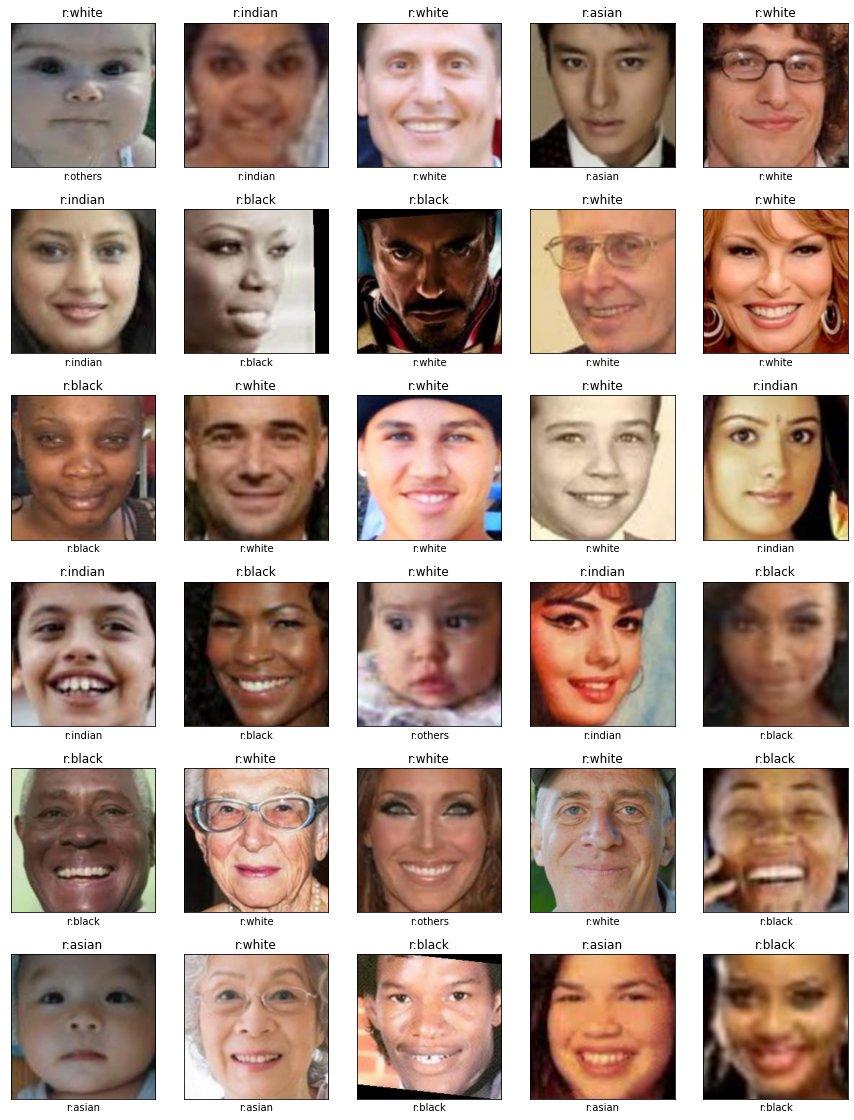

In [0]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('r:{}'.format(ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('r:{}'.format(ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
model_name = 'Race_2nd.h5'
save_dir = '/content/drive/My Drive/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Race_2nd.h5 


white


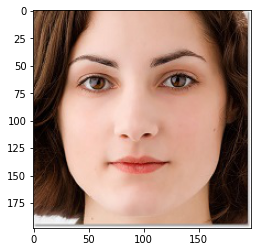

In [0]:
img = plt.imread('/content/main-cropped.jpg')
plt.imshow(img)
race_pred = model.predict(np.expand_dims(img/255, axis=0))
print(ID_RACE_MAP[race_pred.argmax(axis=-1)[0]])

white


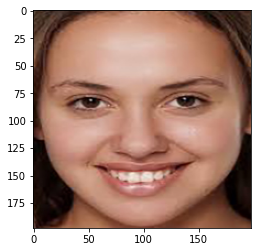

In [0]:
img = plt.imread('/content/ima2ges.jpg')
plt.imshow(img)
race_pred = model.predict(np.expand_dims(img/255, axis=0))
print(ID_RACE_MAP[race_pred.argmax(axis=-1)[0]])

black


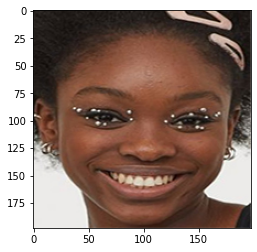

In [0]:
img = plt.imread('/content/qq6q13z5.jpg')
plt.imshow(img)
race_pred = model.predict(np.expand_dims(img/255, axis=0))
print(ID_RACE_MAP[race_pred.argmax(axis=-1)[0]])

white


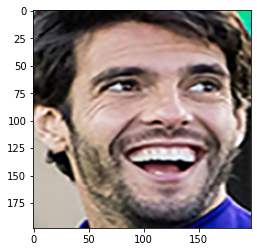

In [0]:
img = plt.imread('/content/1bb.jpg')
plt.imshow(img)
race_pred = model.predict(np.expand_dims(img/255, axis=0))
print(ID_RACE_MAP[race_pred.argmax(axis=-1)[0]])